In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

from IPython.display import display, Markdown
%load_ext autoreload
%autoreload 2

sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
import illustris_python as il

In [3]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [4]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

## Halo viz

In [5]:
def plot_halo_dark(base_path_dark, snap_num, halo):
        # Dark sim
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    
    s_dm = 0.6
    alpha = 0.3
    # want absolute positions, not shifted, so get directly from illustris
    halo_dark_dm = il.snapshot.loadHalo(base_path_dark,snap_num,halo.idx_halo_dark,'dm')
    x_halo_dark_dm = halo_dark_dm['Coordinates']
    #x_halo_dark_dm = halo.shift_x(x_halo_dark_dm, center='x_minPE')
    ax.scatter(x_halo_dark_dm[:,0], x_halo_dark_dm[:,1], 
               s=s_dm, alpha=alpha, marker='.', color='darkblue', label='Dark halo DM')  
    ax.set_aspect('equal')
    plt.axis('off')

In [6]:
def plot_halo_hydro(base_path_hydro, snap_num, halo):
        # Dark sim
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    
    s_dm = 0.6
    s_hydro = 0.1
    alpha = 0.3

    # Hydro sim
    halo_hydro_dm = il.snapshot.loadHalo(base_path_hydro,snap_num,halo.idx_halo_hydro,'dm')
    x_halo_hydro_dm = halo_hydro_dm['Coordinates']
    #x_halo_hydro_dm = halo.shift_x(x_halo_hydro_dm, center='x_minPE')
    ax.scatter(x_halo_hydro_dm[:,0], x_halo_hydro_dm[:,1], 
               s=s_dm, alpha=alpha, marker='.', color='rebeccapurple', label='Hydro halo DM')

    halo_hydro_stars = il.snapshot.loadHalo(base_path_hydro,snap_num,halo.idx_halo_hydro,'stars')
    if halo_hydro_stars['count'] > 0:
        x_halo_hydro_stars = halo_hydro_stars['Coordinates']
        ax.scatter(x_halo_hydro_stars[:,0], x_halo_hydro_stars[:,1], 
                   s=s_hydro, alpha=alpha, marker='.', color='darkorange', label='Hydro halo stars')

    ax.set_aspect('equal')
    plt.axis('off')

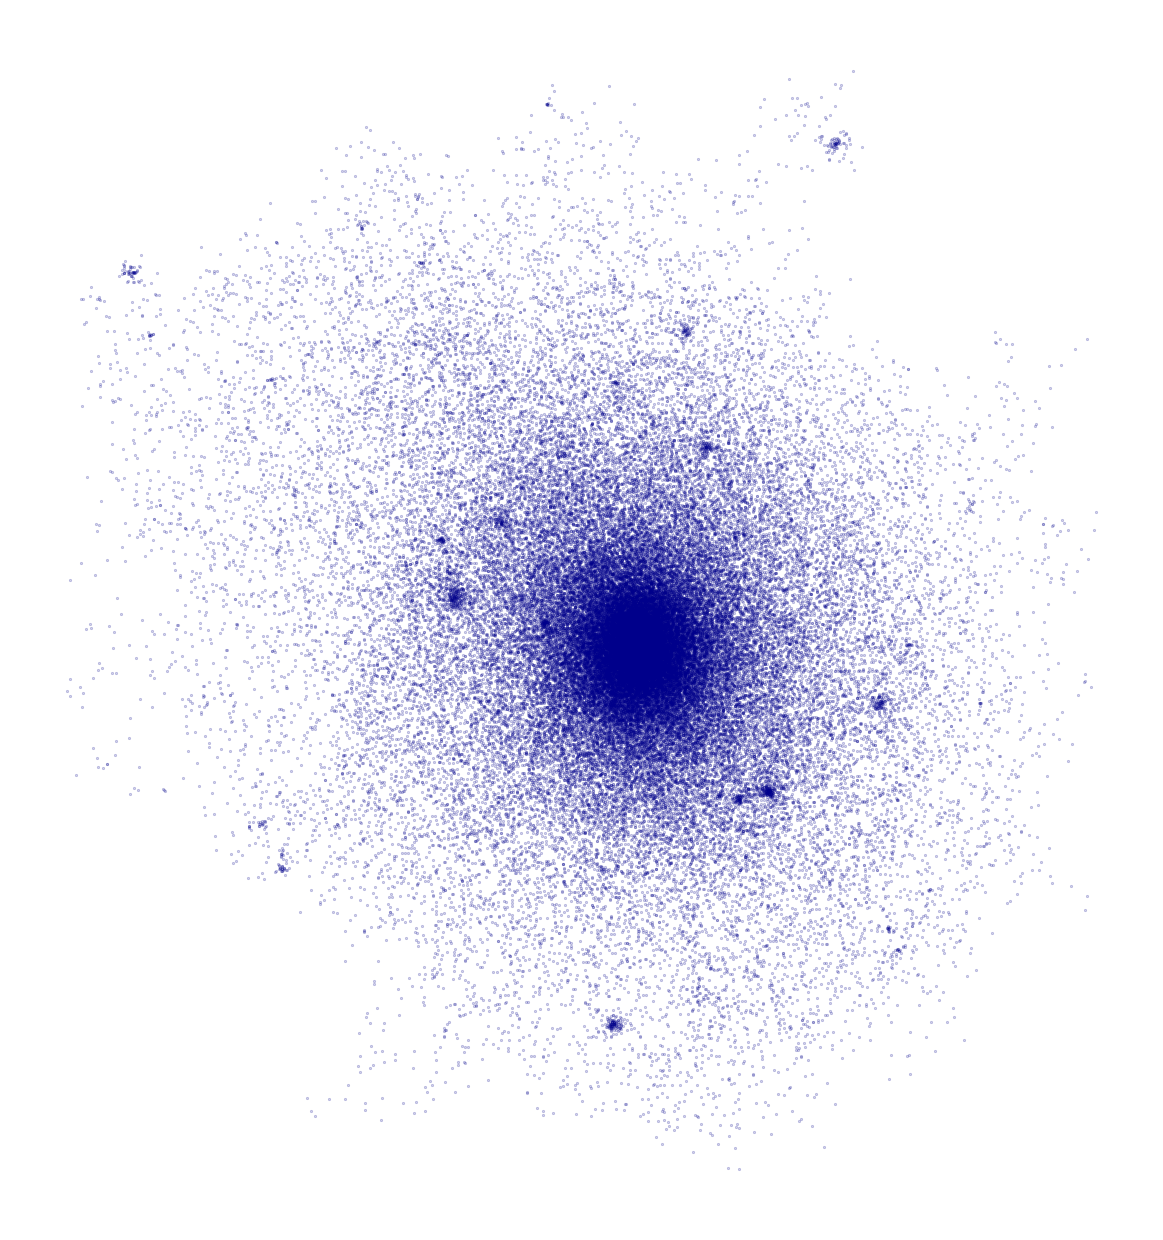

In [7]:
#idx_halo_dark = 3000
idx = 3000 
halo = sim_reader.dark_halo_arr[idx]
plot_halo_dark(sim_reader.base_path_dark, sim_reader.snap_num, halo)

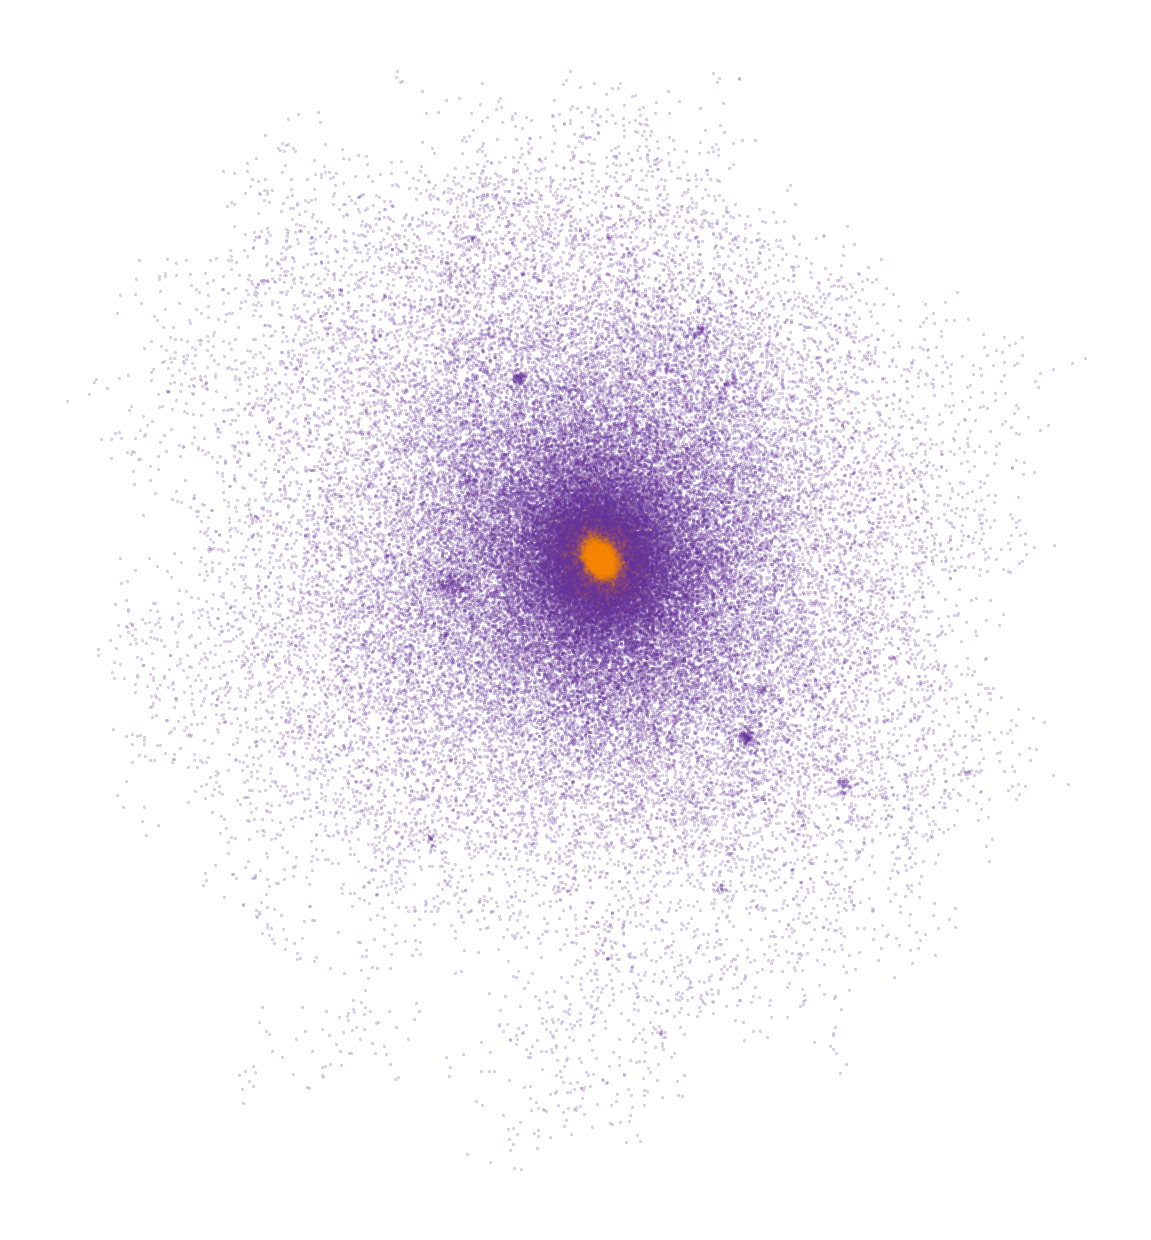

In [8]:
plot_halo_hydro(sim_reader.base_path_hydro, sim_reader.snap_num, halo)

## Geometric feature viz

In [6]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPEsub_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin1_twin_xminPEsub_rall.npy


In [7]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [8]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)
geo_feature_arr_pseudo = utils.transform_pseudotensors(geo_feature_arr_rebinned)

In [9]:
n_rbins=8
r_edges = np.linspace(0, 1, n_rbins+1) # in units of r200
r_edges_outsider200 = np.array([2, 3, 10])
r_edges = np.concatenate((r_edges, r_edges_outsider200))
print(r_edges)

[ 0.     0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     2.
  3.    10.   ]


In [10]:
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])

In [11]:
sim_reader.add_catalog_property_to_halos('x_minPE')

In [12]:
cmap_shifted = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, stop=1.0)

In [38]:
def plot_halo_dark_geometric(base_path_dark, snap_num, m_dmpart, halo, bin_edges_frac):
    
    r200 = halo.catalog_properties['r200m']
    bin_edges = r200*np.array(bin_edges_frac)

    n_bins = len(bin_edges)-1
    #colors = ['mediumblue', 'lightsteelblue', 'cornflowerblue']
    
    # Dark sim
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    
    s_dm = 0.6
    alpha = 0.3
    # want absolute positions, not shifted, so get directly from illustris
    halo_dark_dm = il.snapshot.loadHalo(base_path_dark,snap_num,halo.idx_halo_dark,'dm')
    x_halo_dark_dm = halo_dark_dm['Coordinates']
    x_minPE = halo.catalog_properties['x_minPE']
    dists = np.sqrt((x_halo_dark_dm[:,0]-x_minPE[0])**2 +
                    (x_halo_dark_dm[:,1]-x_minPE[1])**2 +
                    (x_halo_dark_dm[:,2]-x_minPE[2])**2)
    
    #cmap = matplotlib.cm.get_cmap(cmap_shifted)
    cmap = cm.cool
    #m_200 = halo.catalog_properties['m200m']
    m_max = 1
    
    
    masses = []
    for i in range(n_bins):
        x_inbin = x_halo_dark_dm[(dists >= bin_edges[i]) & (dists < bin_edges[i+1])]
        m_inbin = len(x_inbin)*m_dmpart
        masses.append(m_inbin)
        
    m_200 = np.sum(masses[:2])    
    for i in range(n_bins):   
        x_inbin = x_halo_dark_dm[(dists >= bin_edges[i]) & (dists < bin_edges[i+1])]
        print(masses[i]/m_200)
        color = cmap(masses[i]/m_200)
        scat = ax.scatter(x_inbin[:,0], x_inbin[:,1], 
               s=s_dm, alpha=alpha, marker='.', color=color, label='Dark halo DM', zorder=0)  
        
        com_bin = np.mean(x_inbin, axis=0)
        ax.arrow(x_minPE[0], x_minPE[1], com_bin[0]-x_minPE[0], com_bin[1]-x_minPE[1], head_width=20,
                  facecolor=color, edgecolor='k', zorder=2)
        #ax.scatter(com_bin[0], com_bin[1], marker='o', color=color, edgecolor='k', s=150)
        
        if i < n_bins-1:
            circle_r200 = plt.Circle((x_minPE[0], x_minPE[1]), bin_edges[i+1], color='dimgrey', fill=False, lw=1.5)
            ax.add_patch(circle_r200)
    
    ax.scatter(x_minPE[0], x_minPE[1], marker='+', color='k', s=200, lw=3, zorder=1)

    #scat.set_clim(0, 0.8)
    sm = cm.ScalarMappable(cmap=cmap)
    #sm.set_clim(0.1, 0.6)
    cbar = fig.colorbar(sm, shrink=0.7, pad=0.04)
    cbar.set_label(label=r'$M_\mathrm{bin}/M_{200}$', size=28)#, extend='max')
    cbar.ax.tick_params(labelsize=24) 
    
    ax.set_aspect('equal')
    plt.axis('off')

In [39]:
len(sim_reader.dark_halo_arr), len(geo_feature_arr_pseudo)

(20098, 20098)

66.57135
0.4652189405336923
0.5347810594663077
0.2446947501781614


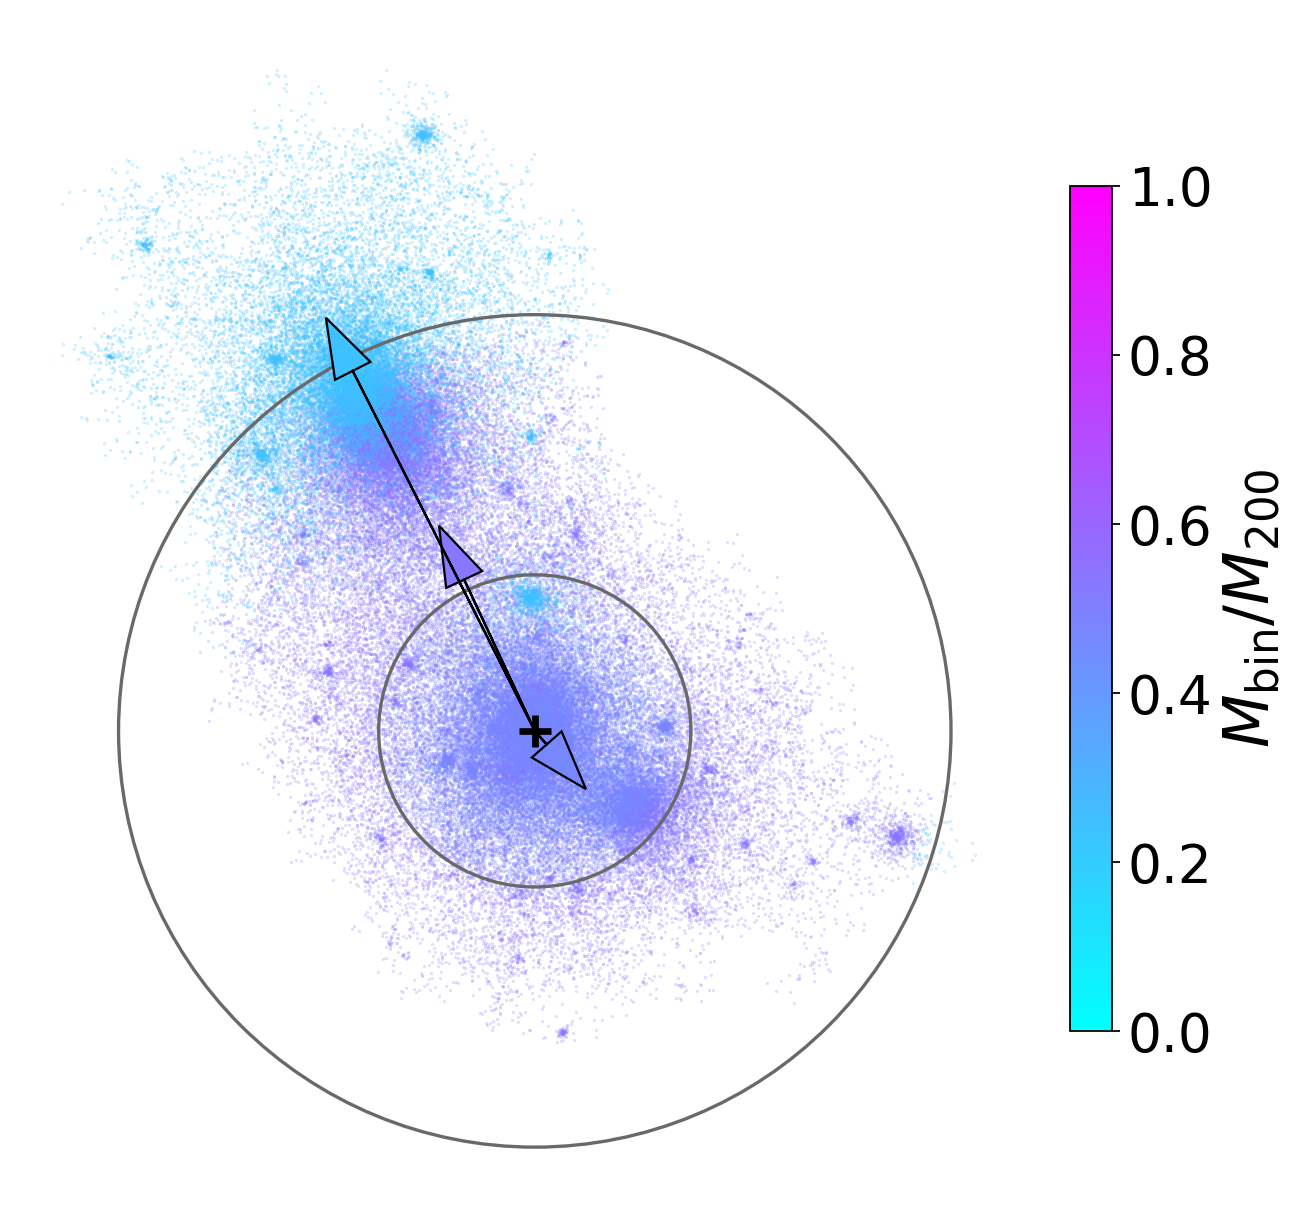

In [40]:
bin_edges_frac = [0, 3/8, 1, 10]
idx = 2197 
halo = sim_reader.dark_halo_arr[idx]
print(halo.catalog_properties['m200m'])
geos = geo_feature_arr_pseudo[idx]
plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart, halo, bin_edges_frac)

0.7387850572894303
0.2612149427105698
0.0007570792560283849


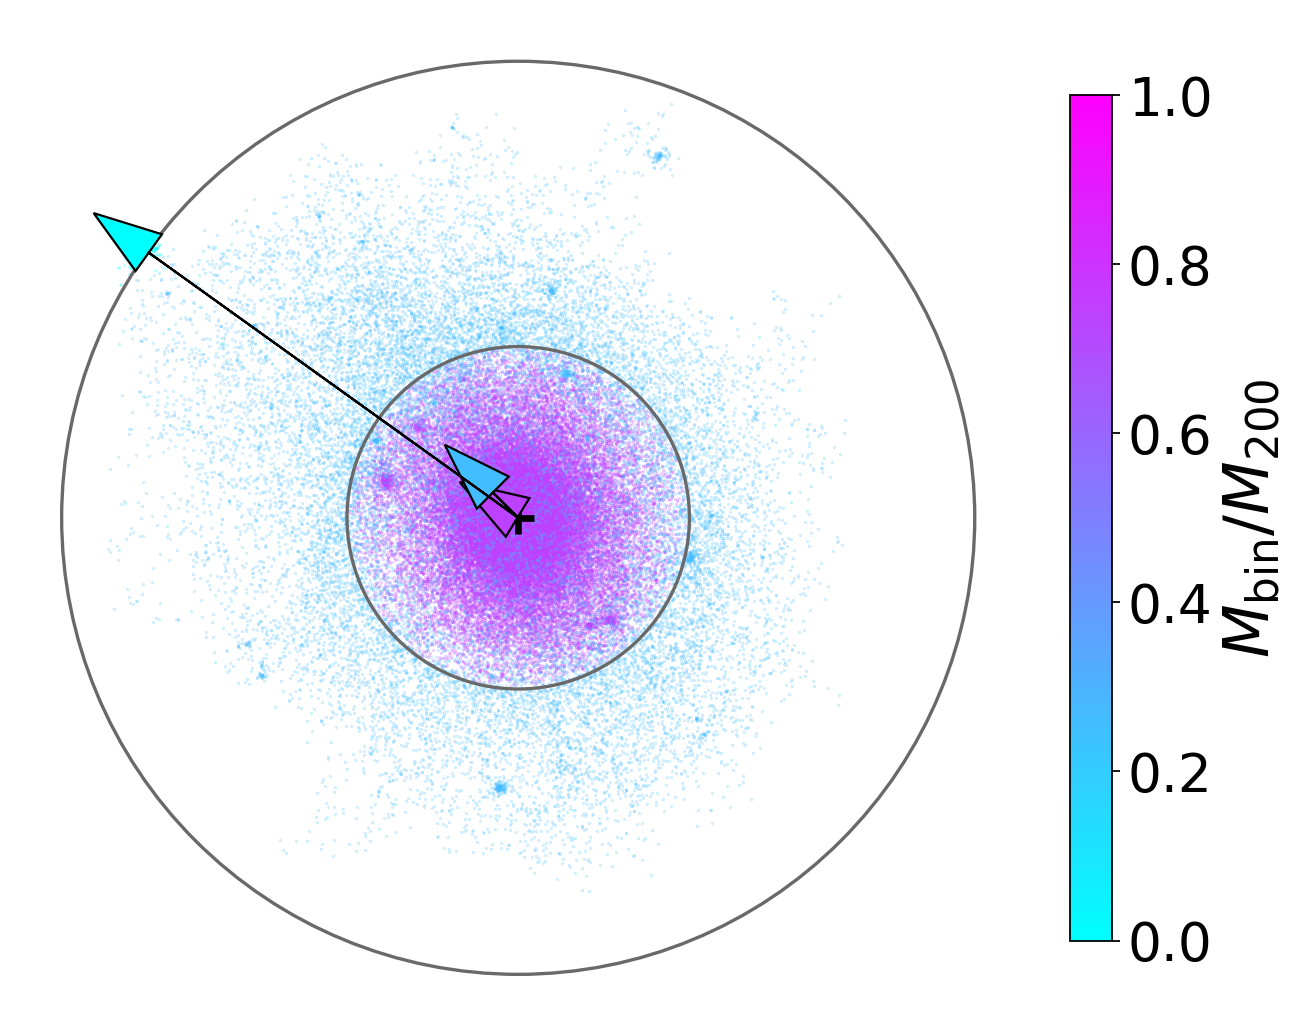

In [41]:
bin_edges_frac = [0, 3/8, 1, 10]
idx = 3000 
halo = sim_reader.dark_halo_arr[idx]
plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart, halo, bin_edges_frac)

0.5729136270790779
0.4270863729209221
0.02141814998540998


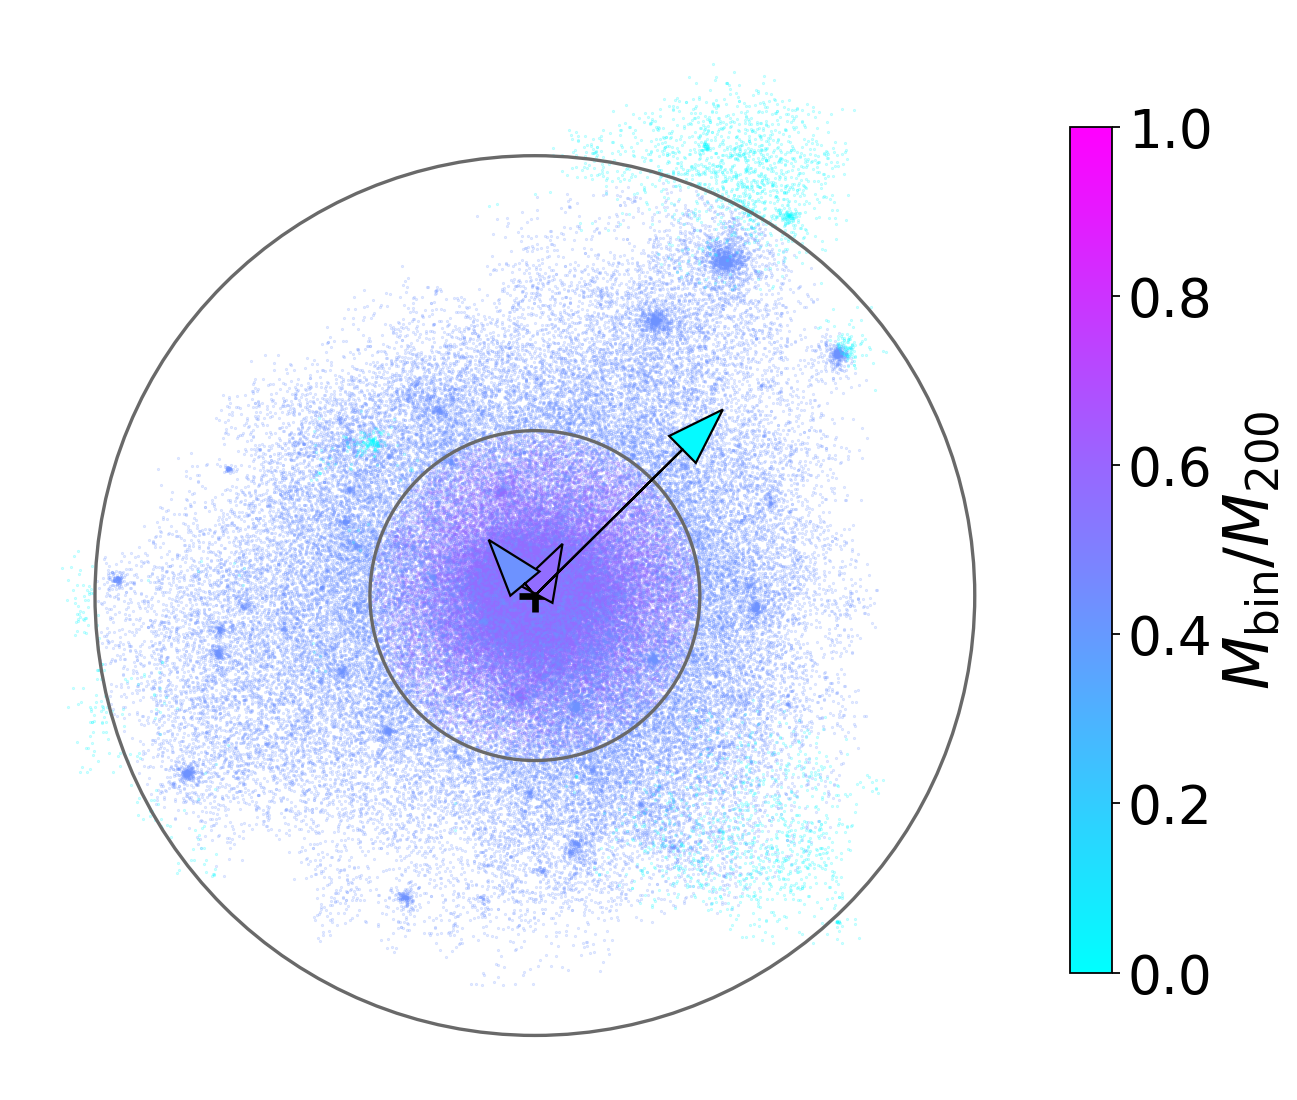

In [42]:
bin_edges_frac = [0, 3/8, 1, 10]
idx = 2000 
halo = sim_reader.dark_halo_arr[idx]
plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart, halo, bin_edges_frac)

# Mstellar predictions

In [13]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])

log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)

N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 20098


In [14]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_pseudo)
scalar_featurizer.rescale_geometric_features(m_200m, r_200m, v_200m)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((m_200m, r_200m, v_200m)).T
x_features_extra = np.log10(x_features_extra)   

### Load in scalar features

In [15]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_pseudo_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

print('loading')
scalar_featurizer.load_features(fn_scalar_features)

loading


In [18]:
feature_imp_dir = f'../data/feature_importance/feature_importance_{sim_name}'
feature_tag = '_mstellar'
fn_feature_imp = f'{feature_imp_dir}/feature_importance{halo_tag}{geo_tag}{scalar_tag}{feature_tag}.npy'
feature_imp_results = feature_importance.load_feature_importance(fn_feature_imp)
idxs_ordered_best, errors_best, chi2s_best, groups = feature_imp_results

### Split train-val-test

In [19]:
frac_train = 0.70
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

print(len(idx_train), len(idx_test), len(idx_val))

14068 3015 3015


### Uncertainties & powerlaw

In [20]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
uncertainties_genel2019 = utils.get_uncertainties_genel2019(y_label_name, log_m_stellar+log_mass_shift, sim_name=sim_name)

In [21]:
log_m_200m_train = log_m_200m[idx_train]
log_m_stellar_train = log_m_stellar[idx_train]
uncertainties_genel2019_train = uncertainties_genel2019[idx_train]
y_val_current_powerlaw_fit_train, params_best_fit, params_initial_guess = utils.fit_broken_power_law(
                                                        log_m_200m_train, log_m_stellar_train, 
                                                        uncertainties=uncertainties_genel2019_train, 
                                                        return_initial_guess=True)
y_val_current_powerlaw_fit = utils.broken_power_law(log_m_200m, *params_best_fit)

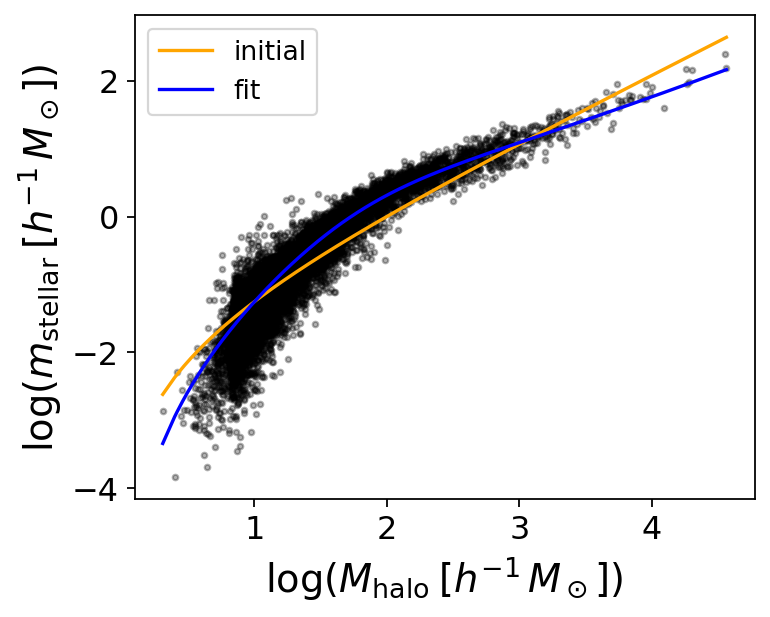

In [22]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m_train)
y_initial_train = utils.broken_power_law(log_m_200m_train, *params_initial_guess)
plt.scatter(log_m_200m_train[idx_m_200m], log_m_stellar_train[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m_train[idx_m_200m], y_initial_train[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m_train[idx_m_200m], y_val_current_powerlaw_fit_train[idx_m_200m], color='blue', label='fit')
plt.xlabel(utils.label_dict[x_label_name])
plt.ylabel(utils.label_dict[y_label_name])
plt.legend(fontsize=12)

### Fitter

In [23]:
inferno_r = matplotlib.cm.inferno_r
inferno_shifted = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:277: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


In [24]:
def plot_pred_vs_true_hist(y_label_name, y_true, y_pred,
                      text_results='',
                      x_lim=(7,12), y_lim=(7,12)):
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    bins = np.linspace(y_lim[0], y_lim[1], 100)
    plt.hist2d(y_true, y_pred, bins=bins, cmap=inferno_shifted, cmin=1)
    cbar = plt.colorbar(label='number of test objects', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)
    
    true_line = np.linspace(*x_lim)
    plt.plot(true_line, true_line, color='grey', zorder=0)

    # labels & adjustments
    plt.xlabel(y_label + ', true')
    plt.ylabel(y_label + ', predicted')

    ax.set_aspect('equal')
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)

    plt.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)

In [25]:
def plot_residual_vs_true_hist(y_label_name, y_true, y_pred,
                      text_results='',
                      x_lim=(7,12), y_lim=(-1,1)):
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    bins_x = np.linspace(x_lim[0], x_lim[1], 100)
    bins_y = np.linspace(y_lim[0], y_lim[1], 100)
    plt.hist2d(y_true, y_pred-y_true, bins=[bins_x, bins_y], cmap=inferno_shifted, cmin=1)
    cbar = plt.colorbar(label='number of test objects', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)
    
    #true_line = np.linspace(*x_lim)
    #plt.plot(true_line, true_line, color='grey', zorder=0)
    plt.axhline(0, color='grey', zorder=0)
    
    # labels & adjustments
    plt.xlabel(y_label + ', true')
    plt.ylabel(y_label + ', predicted-true')

    #ax.set_aspect('equal')
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)

    plt.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)

In [26]:
def plot_pred_vs_property_hist(x_label_name, y_label_name, x_property, y_true,
                      text_results='',
                      x_lim=(10.5, 14), y_lim=(7, 12)):
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    
    bins_x = np.linspace(x_lim[0], x_lim[1], 100)
    bins_y = np.linspace(y_lim[0], y_lim[1], 100)

    plt.hist2d(x_property, y_true, bins=[bins_x, bins_y], cmap=inferno_shifted, cmin=1)
    cbar = plt.colorbar(label='number of test objects', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)
    
    # labels & adjustments
    x_label = utils.label_dict[x_label_name]
    y_label = utils.label_dict[y_label_name]
    plt.xlabel(x_label)
    plt.ylabel(y_label + ', predicted')
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)

    plt.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)
    return ax

## True SHMR

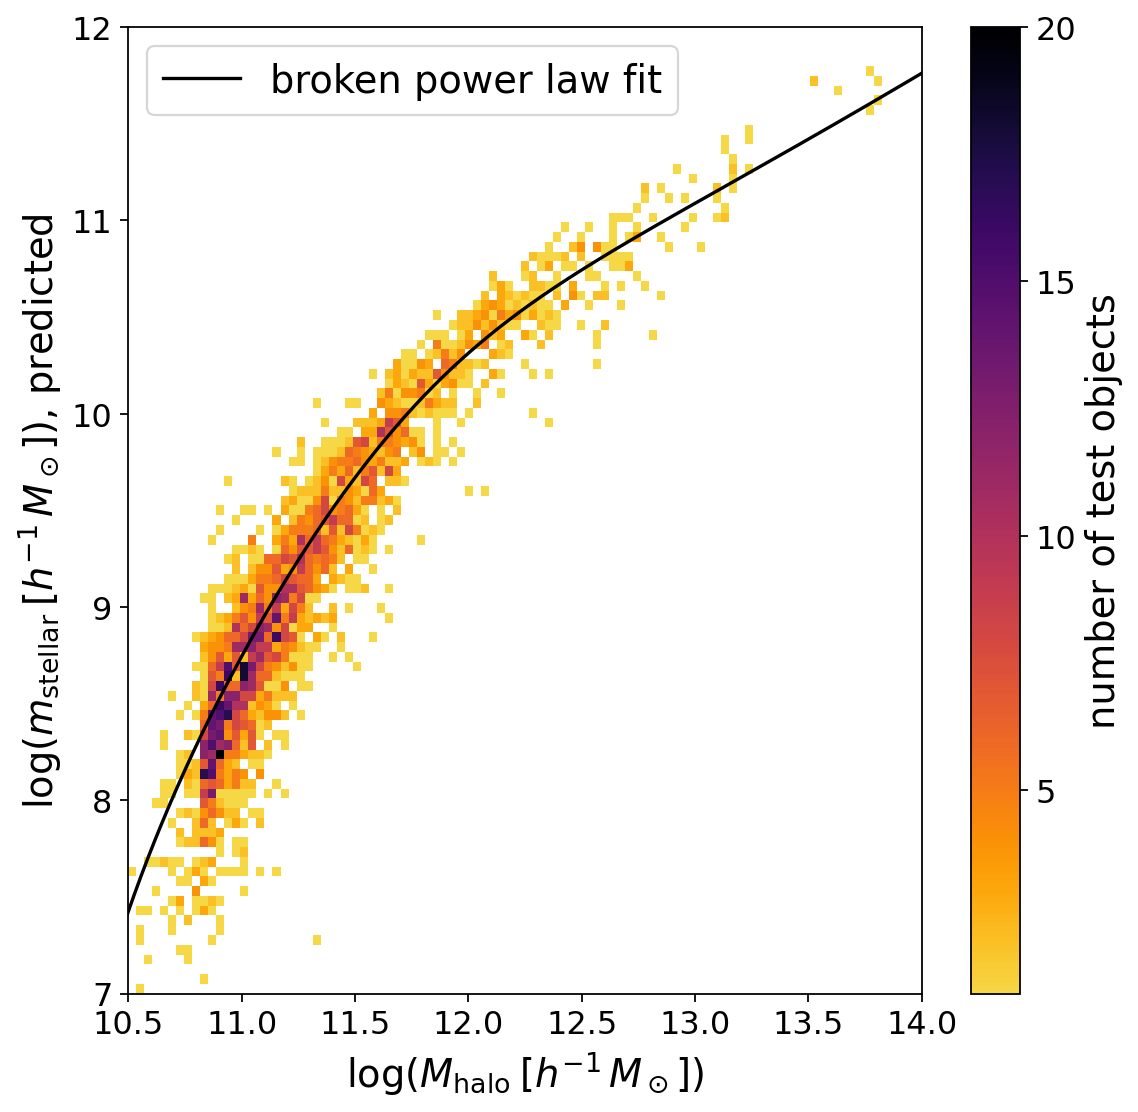

In [27]:
x_property = log_m_200m[idx_test] + log_mass_shift
y_true = log_m_stellar[idx_test] + log_mass_shift
ax = plot_pred_vs_property_hist(x_label_name, y_label_name, x_property, y_true)
ax.plot(log_m_200m_train[idx_m_200m]+log_mass_shift, y_val_current_powerlaw_fit_train[idx_m_200m]+log_mass_shift,
        color='k', label='broken power law fit')
ax.legend()

### Powerlaw + M200 only

In [28]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
x_extra_mtot = np.atleast_2d(np.log10(m_200m)).T
fitter_M = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_extra_mtot)
fitter_M.split_train_test(idx_train, idx_val)
fitter_M.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_M.predict_test()

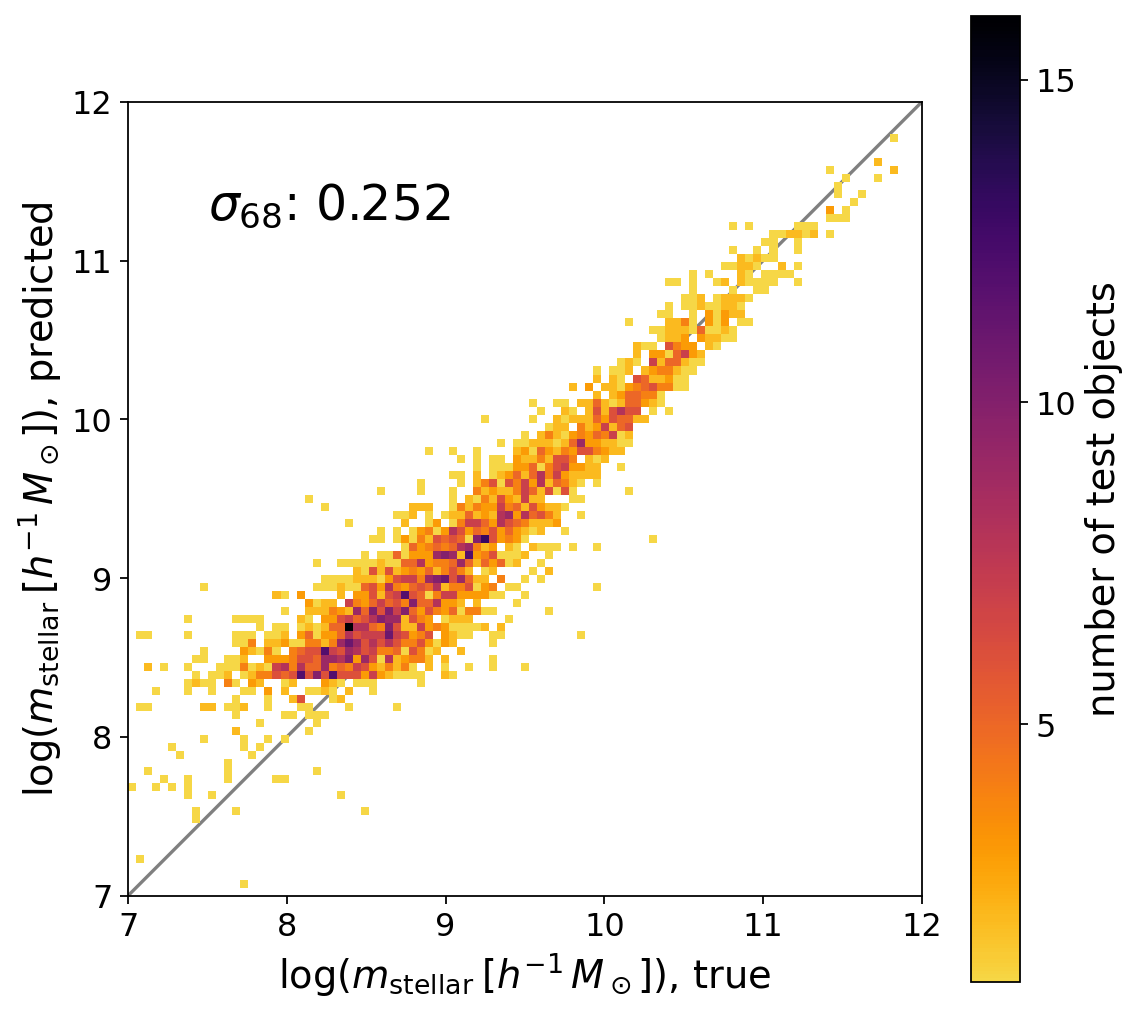

In [29]:
y_true = fitter_M.y_scalar_test + log_mass_shift
y_pred = fitter_M.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_M)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

<AxesSubplot:xlabel='log($M_\\mathrm{halo} \\: [h^{-1} \\, M_\\odot]$)', ylabel='log($m_\\mathrm{stellar} \\: [h^{-1} \\, M_\\odot]$), predicted'>

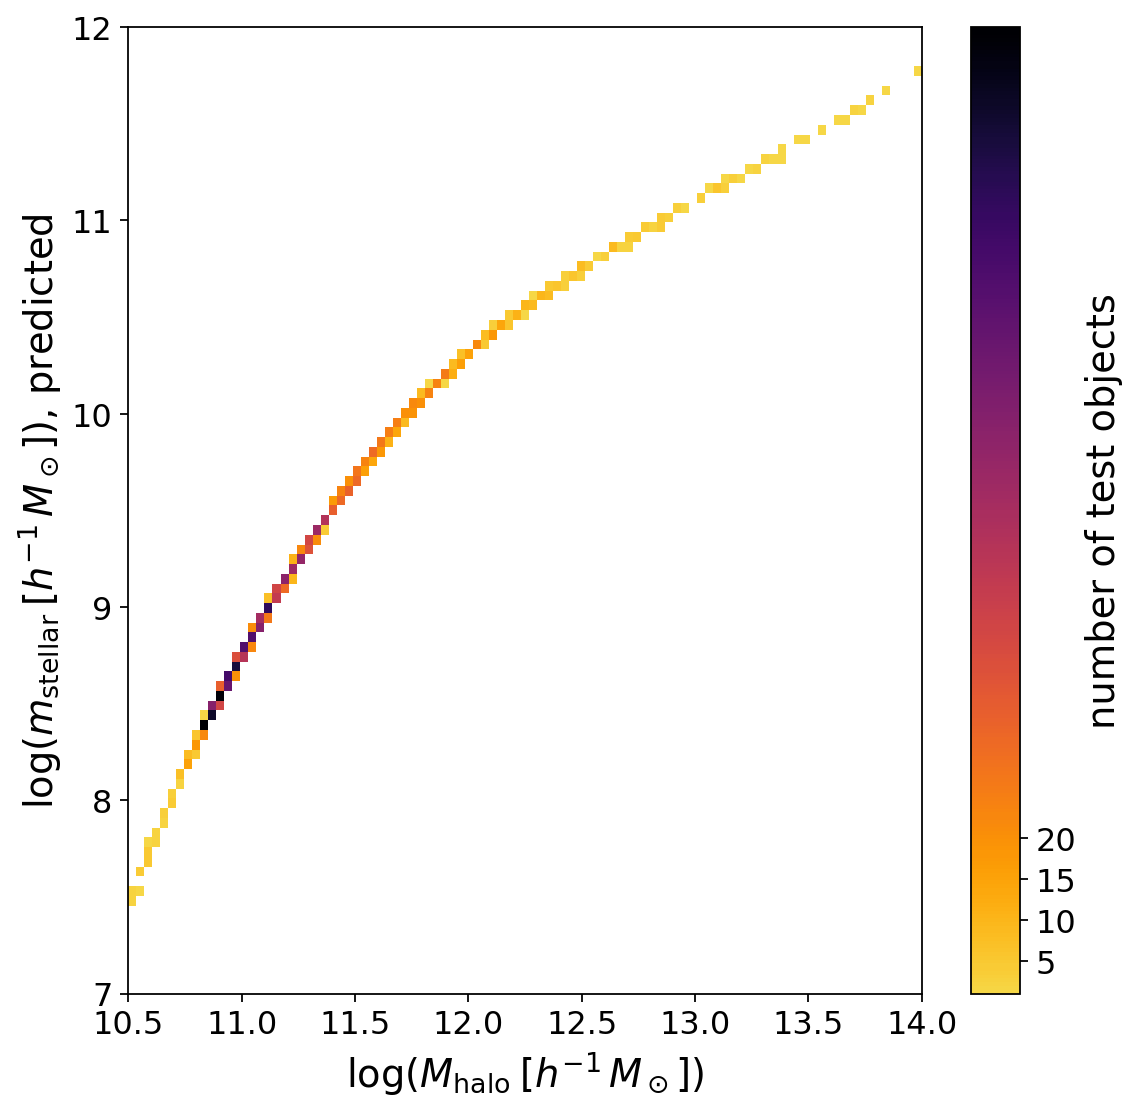

In [30]:
x_property = log_m_200m[fitter_M.idx_test] + log_mass_shift
plot_pred_vs_property_hist(x_label_name, y_label_name, x_property, y_pred)

### All features

In [31]:
fitter_all = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter_all.split_train_test(idx_train, idx_val)
fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all.predict_test()
#plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m)

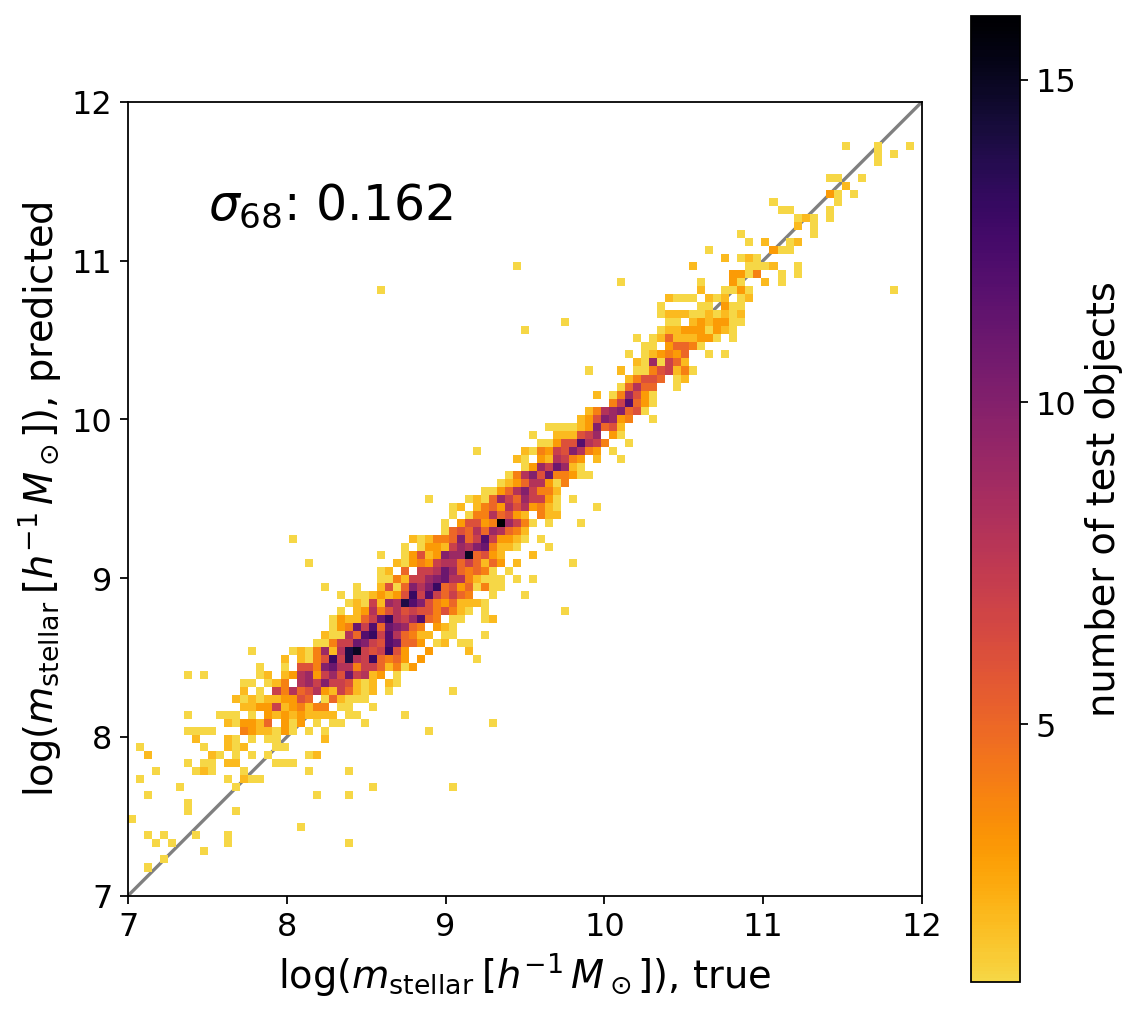

In [32]:
y_true = fitter_all.y_scalar_test + log_mass_shift
y_pred = fitter_all.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_all)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

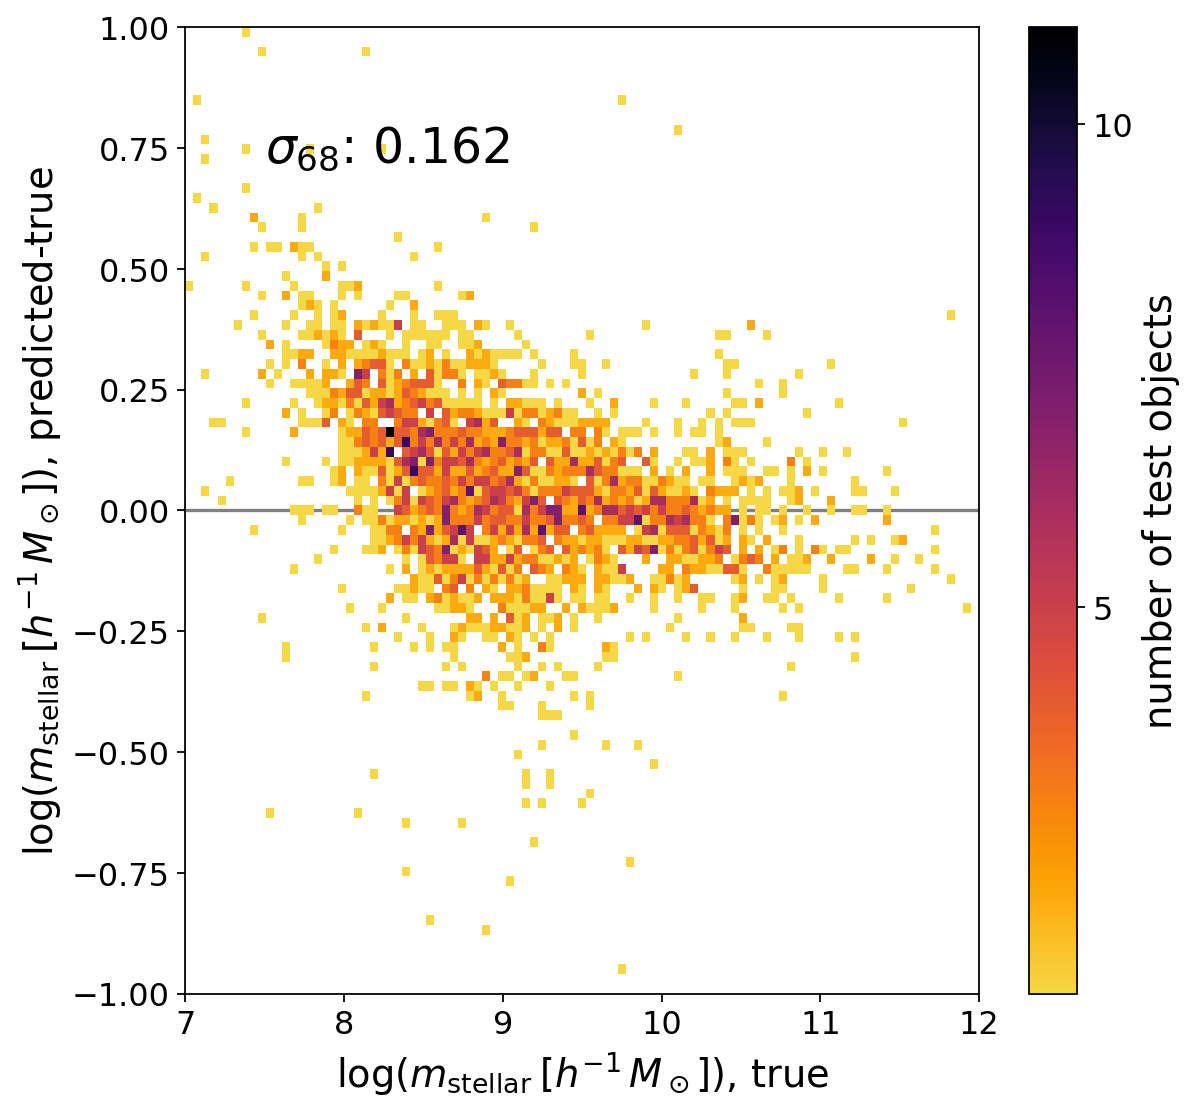

In [33]:
y_true = fitter_all.y_scalar_test + log_mass_shift
y_pred = fitter_all.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_all)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_residual_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

<AxesSubplot:xlabel='log($M_\\mathrm{halo} \\: [h^{-1} \\, M_\\odot]$)', ylabel='log($m_\\mathrm{stellar} \\: [h^{-1} \\, M_\\odot]$), predicted'>

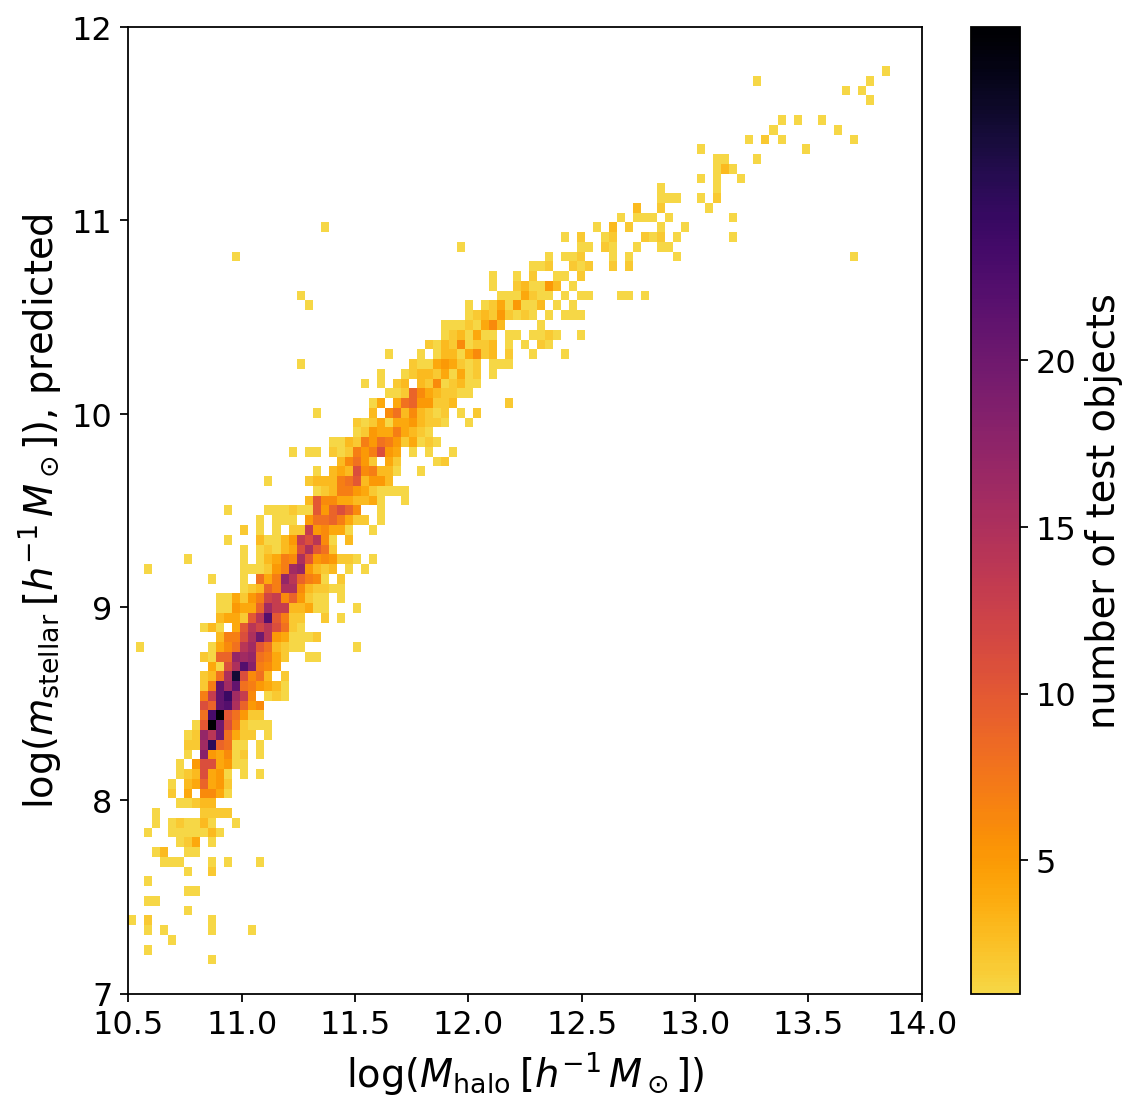

In [34]:
x_property = log_m_200m[fitter_all.idx_test] + log_mass_shift
plot_pred_vs_property_hist(x_label_name, y_label_name, x_property, y_pred)

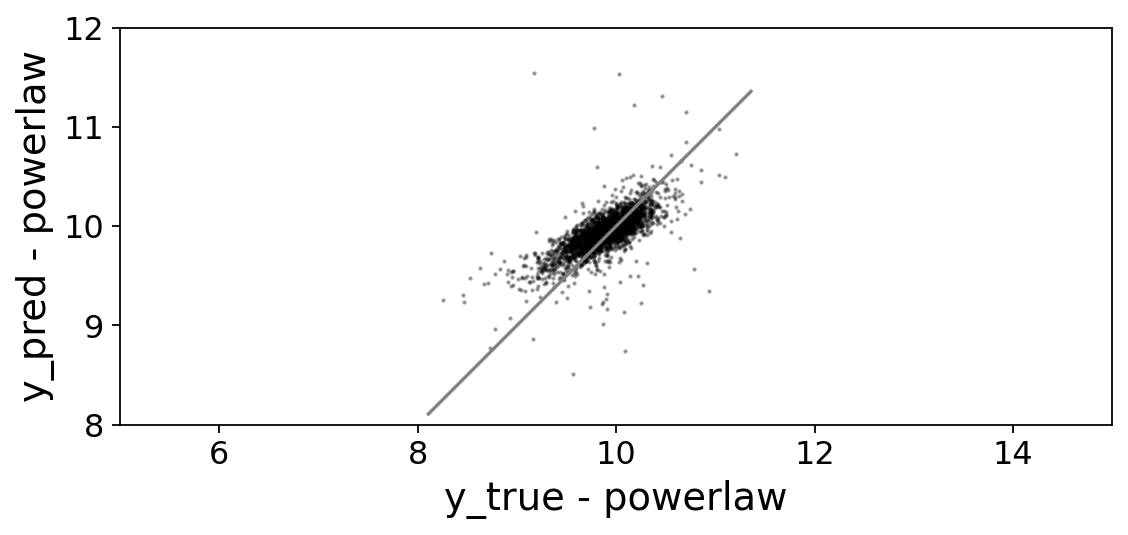

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(y_true-y_val_current_powerlaw_fit[idx_val], y_pred-y_val_current_powerlaw_fit[idx_val], 
            s=1, alpha=0.3, c='k')
xx = np.linspace(*plt.xlim())
plt.plot(xx, xx, color='grey')
plt.xlim(5, 15)
plt.ylim(8, 12)
plt.xlabel('y_true - powerlaw')
plt.ylabel('y_pred - powerlaw')
ax = plt.gca()
ax.set_aspect('equal')

### No powerlaw

In [36]:
fitter_all_nopl = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    np.ones(len(log_m_stellar)), uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter_all_nopl.split_train_test(idx_train, idx_val)
fitter_all_nopl.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all_nopl.predict_test()
#plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m)

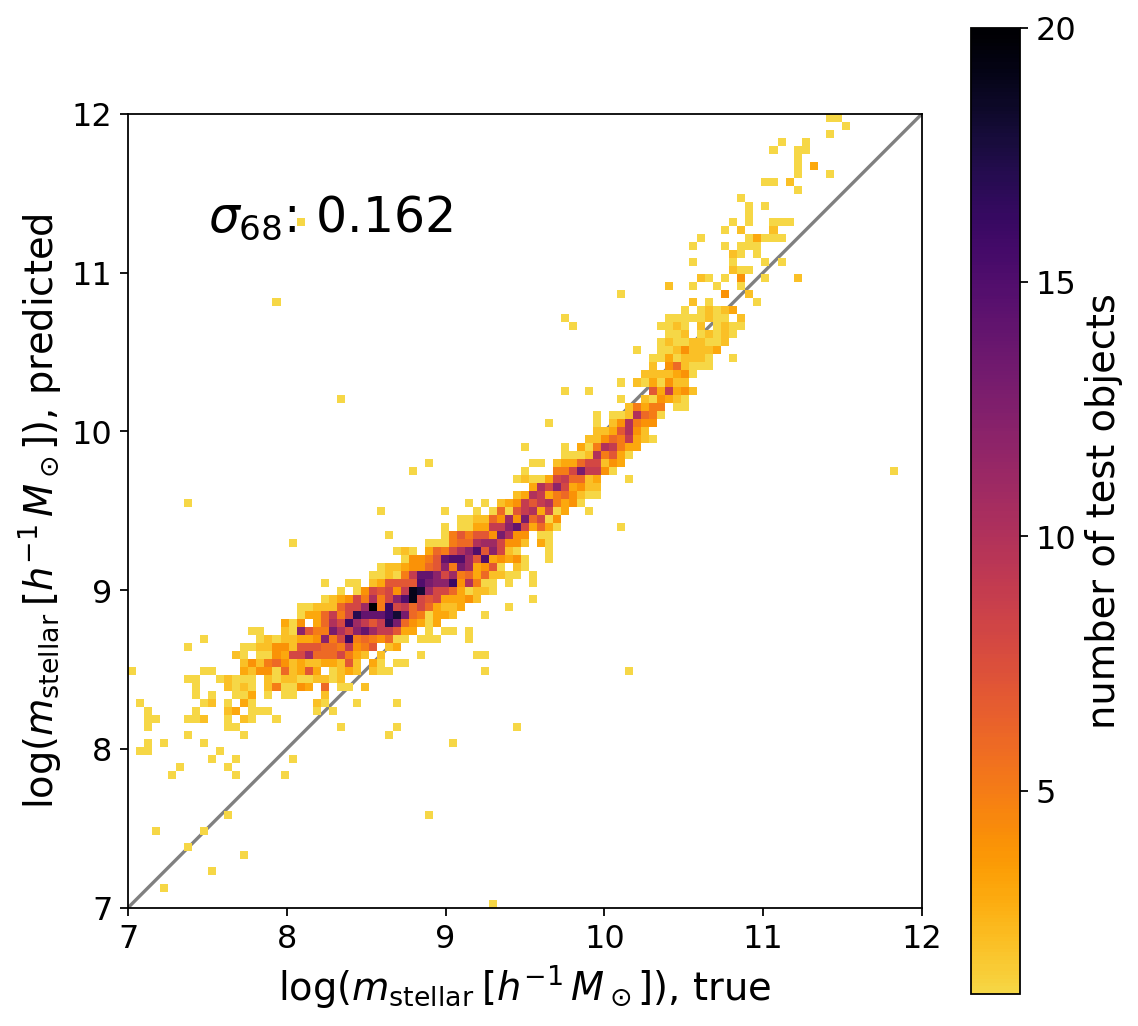

In [37]:
y_true = fitter_all_nopl.y_scalar_test + log_mass_shift
y_pred = fitter_all_nopl.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_all)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

<AxesSubplot:xlabel='log($M_\\mathrm{halo} \\: [h^{-1} \\, M_\\odot]$)', ylabel='log($m_\\mathrm{stellar} \\: [h^{-1} \\, M_\\odot]$), predicted'>

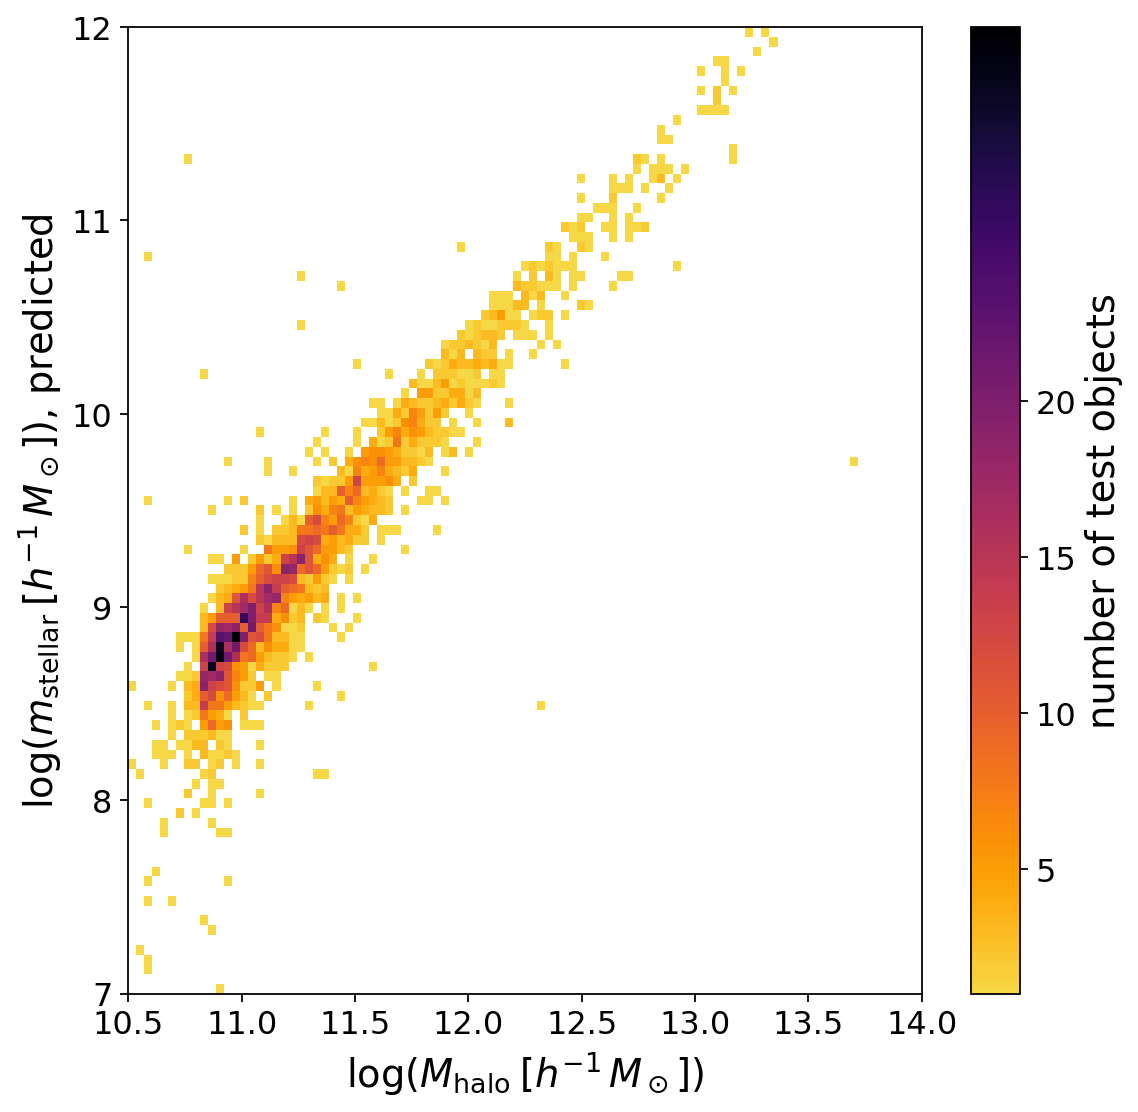

In [39]:
x_property = log_m_200m[fitter_all_nopl.idx_test] + log_mass_shift
plot_pred_vs_property_hist(x_label_name, y_label_name, x_property, y_pred)

### Top N features

In [34]:
top_n = 30
features_topn = scalar_featurizer.scalar_features[:,idxs_ordered_best[:top_n]]

In [35]:
fitter_topn = LinearFitter(features_topn, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter_topn.split_train_test(idx_train, idx_val)
fitter_topn.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_topn.predict_test()
#plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m)

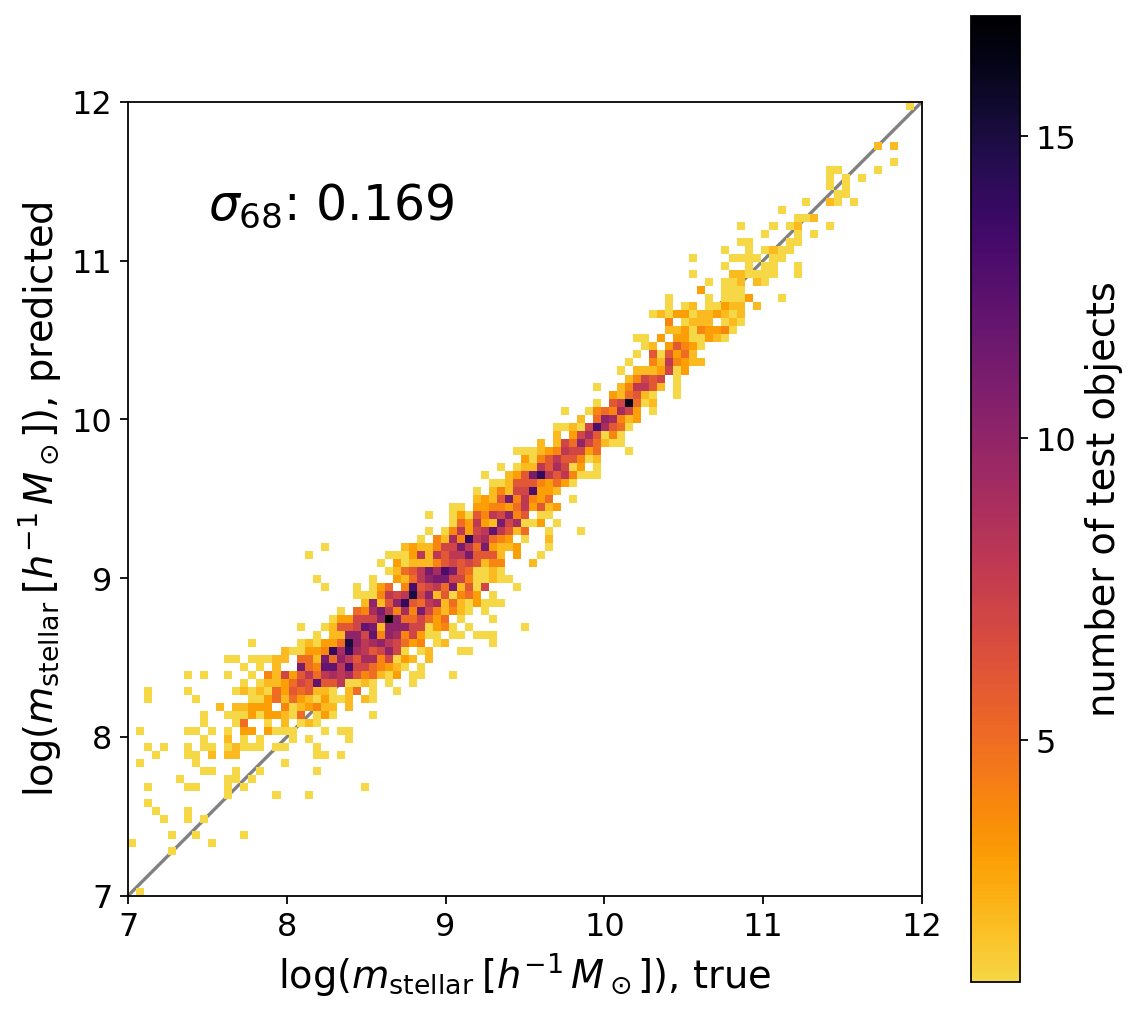

In [36]:
y_true = fitter_topn.y_scalar_test + log_mass_shift
y_pred = fitter_topn.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_topn)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

10.398056 14.342386
5.9197783 12.073954


<AxesSubplot:xlabel='log($M_\\mathrm{halo} \\: [h^{-1} \\, M_\\odot]$)', ylabel='log($m_\\mathrm{stellar} \\: [h^{-1} \\, M_\\odot]$), predicted'>

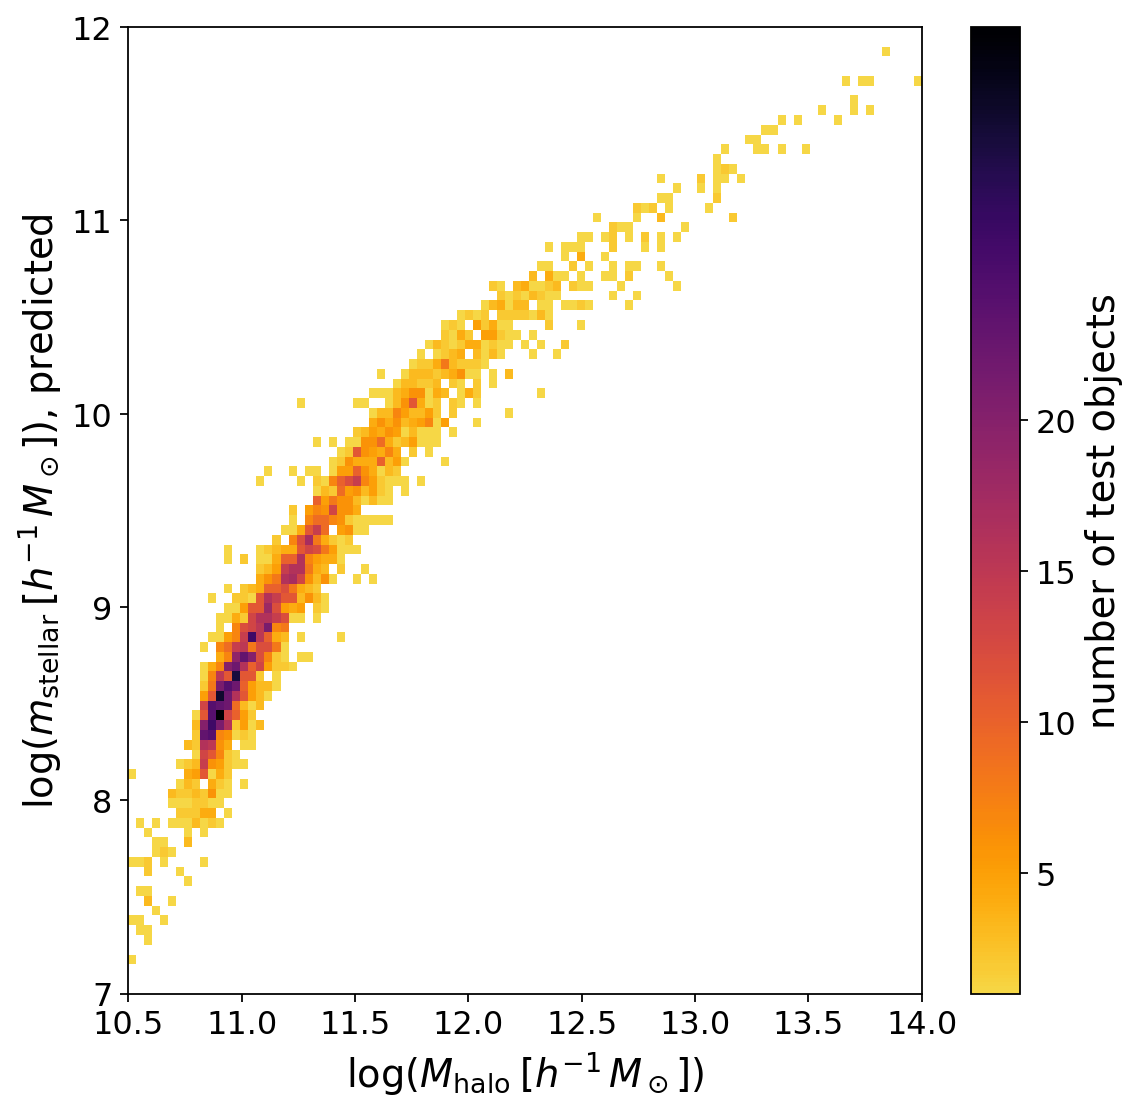

In [37]:
x_property = log_m_200m[fitter_topn.idx_test] + log_mass_shift
print(x_property.min(), x_property.max())
print(y_true.min(), y_true.max())
plot_pred_vs_property_hist(x_label_name, y_label_name, x_property, y_pred)

## Fit geometric features

In [114]:
geo_features = []
for geo_arr in scalar_featurizer.geo_feature_arr:
    geo_features_halo = []
    for g in geo_arr:
        if type(g.value)==np.ndarray or type(g.value)==list:
            geo_features_halo.extend(list(g.value.flatten()))
        else:
            geo_features_halo.append(g.value)
    geo_features.append(geo_features_halo)
geo_features = np.array(geo_features)
print(geo_features.shape)

(20098, 129)


In [123]:
fitter_geo = LinearFitter(geo_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter_geo.split_train_test(idx_train, idx_val)
fitter_geo.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_geo.predict_test()
#plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m)

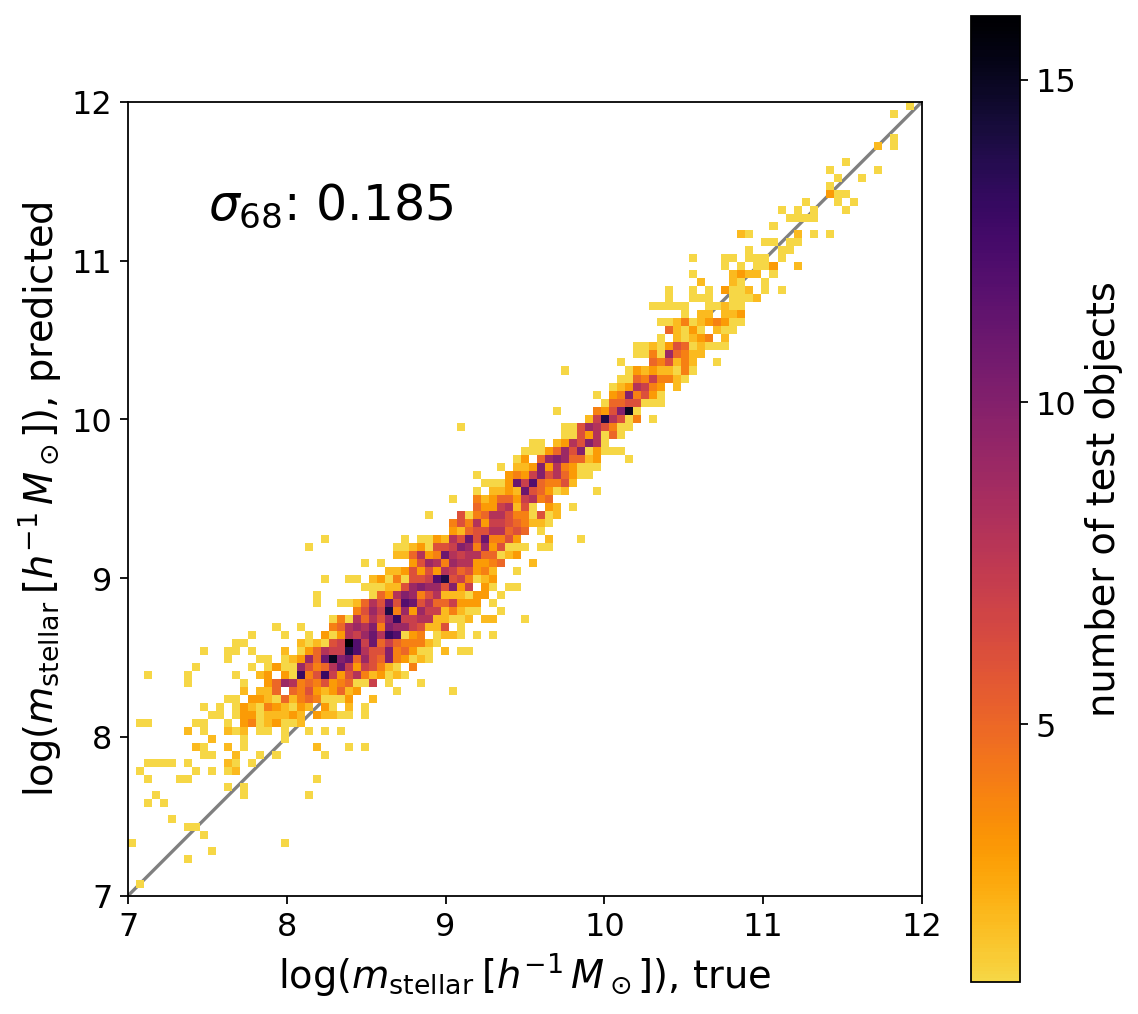

In [124]:
y_true = fitter_geo.y_scalar_test + log_mass_shift
y_pred = fitter_geo.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_geo)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

## Halo catalog features

In [125]:
catalog_feature_names = ['M200c', 'c200c', 'a_form']
idxs_nan_structure_catalog = sim_reader.get_structure_catalog_features(catalog_feature_names)
print(sim_reader.x_catalog_features.shape)

96 halos with NaN values of structure properties detected!
(20098, 3)


In [126]:
x_catalog_features = sim_reader.x_catalog_features
x_catalog_features[:,1] = np.log10(x_catalog_features[:,1])

In [141]:
# Deleting nan entries for now
dark_halos_cat = np.delete(sim_reader.dark_halo_arr, idxs_nan_structure_catalog, axis=0)
x_catalog_features_cat = np.delete(x_catalog_features, idxs_nan_structure_catalog, axis=0)
y_scalar_cat = np.delete(log_m_stellar, idxs_nan_structure_catalog, axis=0)
y_val_current_powerlaw_fit_cat = np.delete(y_val_current_powerlaw_fit, idxs_nan_structure_catalog, axis=0)
uncertainties_genel2019_cat = np.delete(uncertainties_genel2019, idxs_nan_structure_catalog, axis=0)

In [142]:
frac_train = 0.70
frac_test = 0.15

random_ints_cat = np.array([dark_halo.random_int for dark_halo in dark_halos_cat])
idx_train_cat, idx_val_cat, idx_test_cat = utils.split_train_val_test(random_ints_cat, 
                                                                      frac_train=frac_train, frac_test=frac_test)

print(len(idx_train_cat), len(idx_test_cat), len(idx_val_cat))

13936 3081 2985


In [145]:
fitter_cat = LinearFitter(x_catalog_features_cat, y_scalar_cat, 
                y_val_current_powerlaw_fit_cat, uncertainties=uncertainties_genel2019_cat)
fitter_cat.split_train_test(idx_train_cat, idx_test_cat)
fitter_cat.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_cat.predict_test()

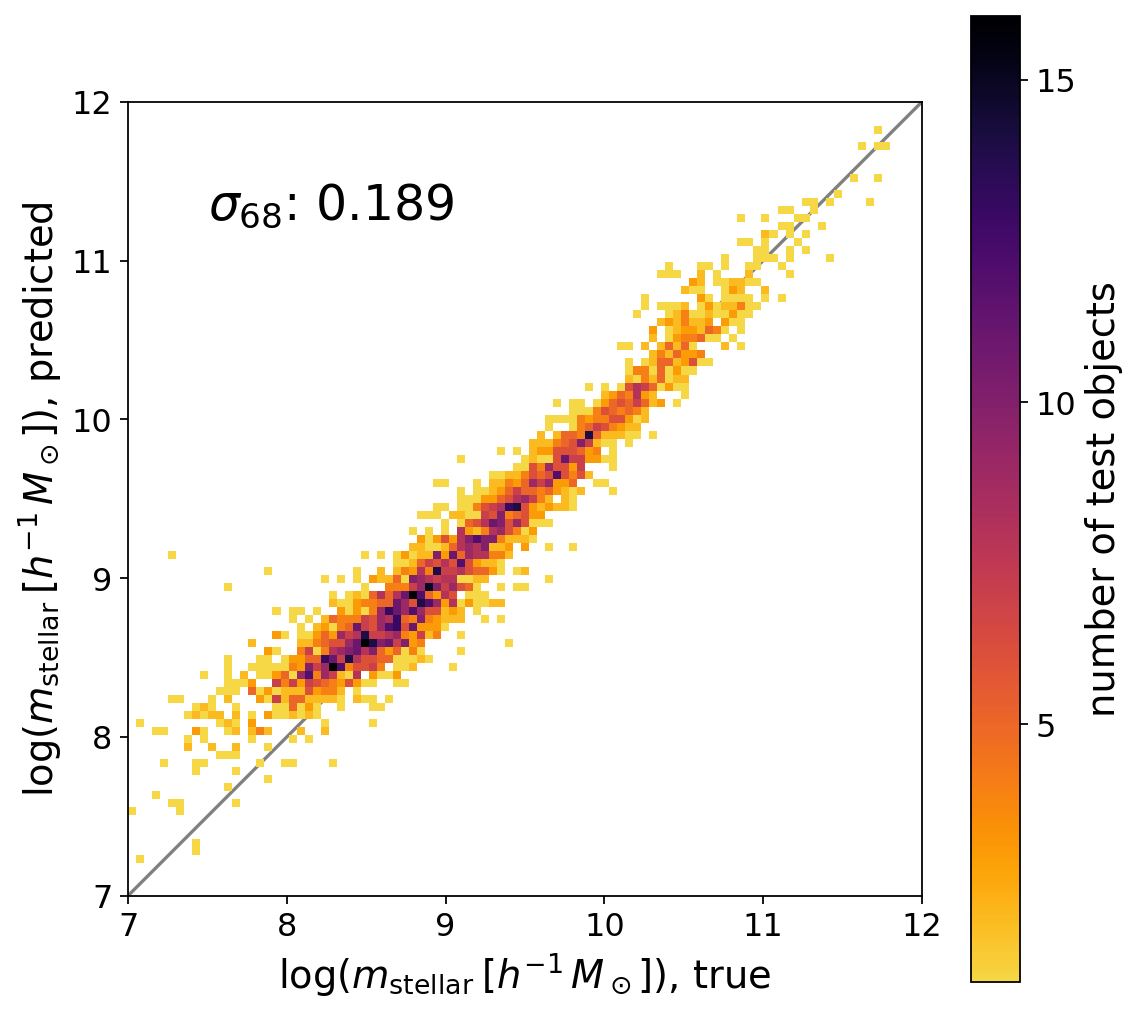

In [146]:
y_true = fitter_cat.y_scalar_test + log_mass_shift
y_pred = fitter_cat.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(fitter_cat)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

# Neural net, all

In [161]:
from neural_net import NNFitter, NeuralNet

In [162]:
nnfitter_all = NNFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                y_val_current_powerlaw_fit, x_features_extra=x_features_extra)
nnfitter_all.split_train_test(idx_train, idx_val)
nnfitter_all.set_up_data()

In [163]:
input_size = nnfitter_all.n_A_features
hidden_size = 64
nnfitter_all.model = NeuralNet(input_size, hidden_size=hidden_size)
nnfitter_all.train(max_epochs=400, learning_rate=0.0007)

Text(0, 0.5, 'loss')

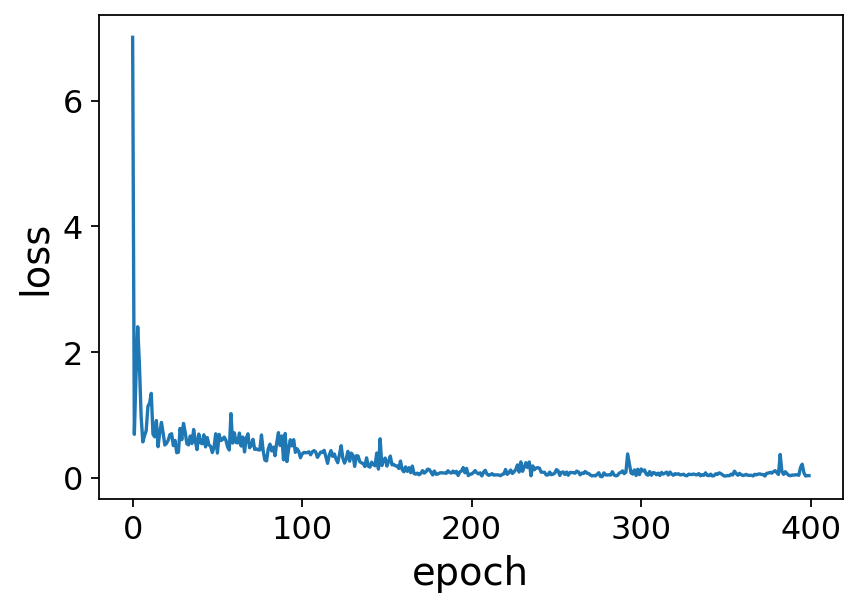

In [164]:
plt.plot(nnfitter_all.loss)
plt.xlabel('epoch')
plt.ylabel('loss')

In [165]:
nnfitter_all.predict_test()

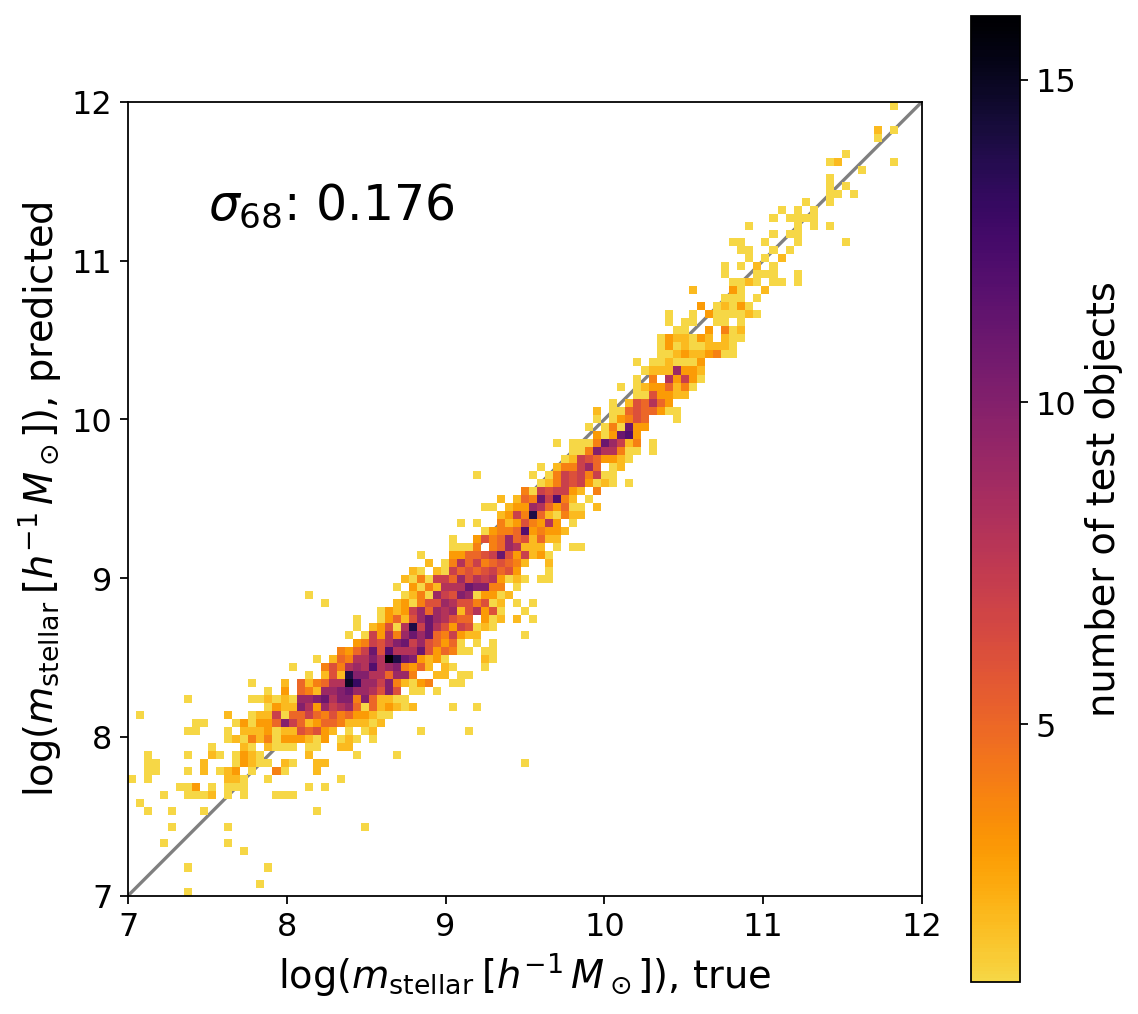

In [166]:
y_true = nnfitter_all.y_scalar_test + log_mass_shift
y_pred = nnfitter_all.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(nnfitter_all)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

## Neural net, no powerlaw:

In [223]:
nnfitter_all_nopl = NNFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                np.ones(len(log_m_stellar)), x_features_extra=x_features_extra)
nnfitter_all_nopl.split_train_test(idx_train, idx_val)
nnfitter_all_nopl.set_up_data()

In [224]:
input_size = nnfitter_all_nopl.n_A_features
hidden_size = 64
nnfitter_all_nopl.model = NeuralNet(input_size, hidden_size=hidden_size)
nnfitter_all_nopl.train(max_epochs=400, learning_rate=0.0007)

Text(0, 0.5, 'loss')

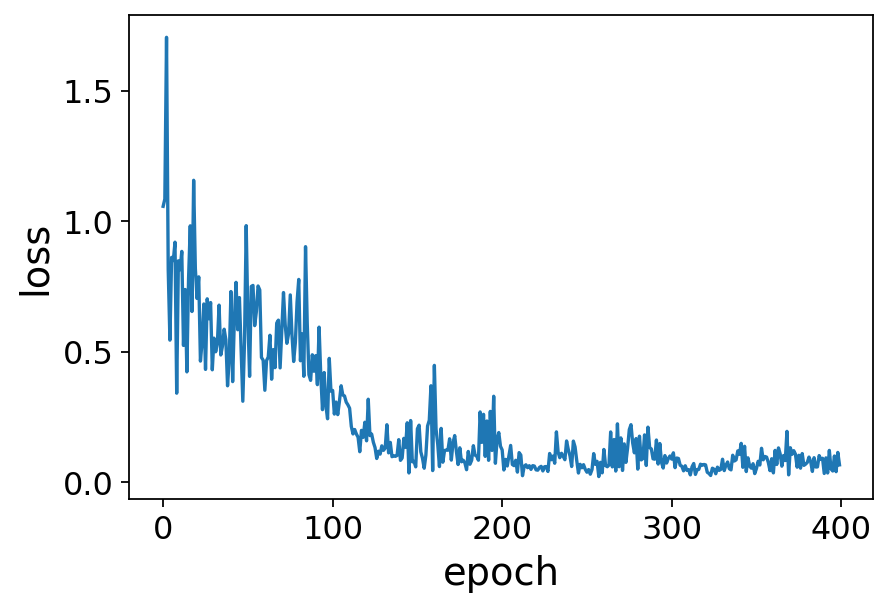

In [225]:
plt.plot(nnfitter_all_nopl.loss)
plt.xlabel('epoch')
plt.ylabel('loss')

In [226]:
nnfitter_all_nopl.predict_test()

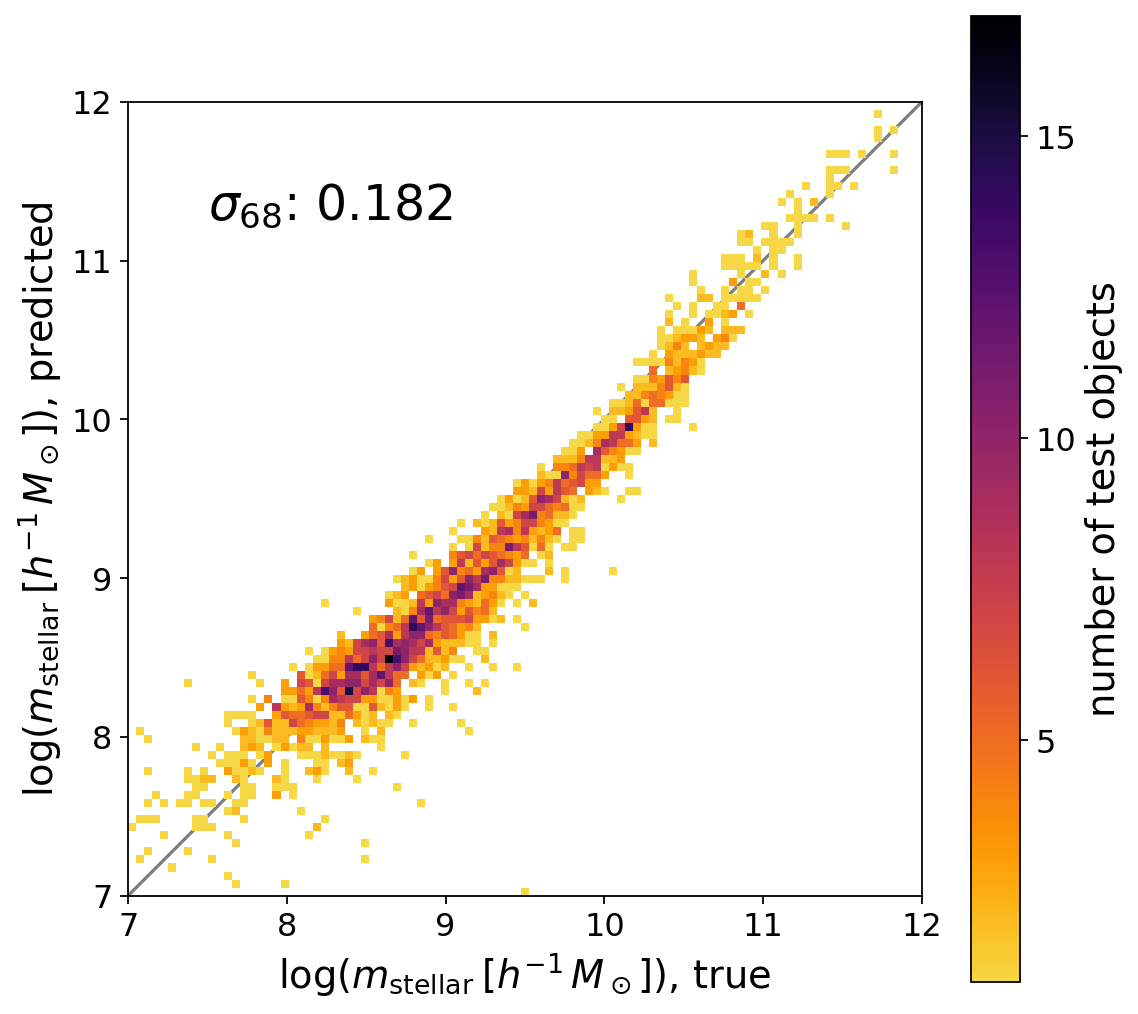

In [227]:
y_true = nnfitter_all_nopl.y_scalar_test + log_mass_shift
y_pred = nnfitter_all_nopl.y_scalar_pred + log_mass_shift
error_inner68_test, _ = utils.compute_error(nnfitter_all_nopl)
error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str)

# Visualize most important features

In [ ]:
s_feats = [s for s in scalar_featurizer.scalar_feature_arr[0]]
for i, idx in enumerate(idxs_ordered_best):
    display(Markdown(f'{i}: {errors_best[i]:.8f}: {scalar_name(s_feats[idx], geo_feature_arr_pseudo)}'))

In [ ]:
nrows = 1
ncols = 3
n_plot = nrows * ncols

In [ ]:
features_all = scalar_featurizer.scalar_features
feature_arr_all = scalar_featurizer.scalar_feature_arr

sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [ ]:
i_best = 9
idx_feat = idxs_ordered_best[i_best]
name_feat = scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)
#name_feat = 'Halos with extreme values of '+scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)
n_each = int(n_plot/2)

idx_halo_low = np.argmin(features_all[:,idx_feat])
idx_halo_med = list(features_all[:,idx_feat]).index(np.percentile(features_all[:,idx_feat],50,interpolation='nearest'))
idx_halo_high = np.argmax(features_all[:,idx_feat])
print(idx_halo_low, idx_halo_med, idx_halo_high)

In [ ]:
idxs_halos = np.array([idx_halo_low, idx_halo_med, idx_halo_high])
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'{name_feat} = {features_all[idx_halo, idx_feat]:.2e}' for idx_halo in idxs_halos]
print(halos)
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=None)

In [ ]:
bin_edges_frac = [0, 3/8, 1, 10]
halo = sim_reader.dark_halo_arr[idx_halo_low]
plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart, halo, bin_edges_frac)

In [ ]:
bin_edges_frac = [0, 3/8, 1, 10]
halo = sim_reader.dark_halo_arr[idx_halo_med]
plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart, halo, bin_edges_frac)

In [ ]:
bin_edges_frac = [0, 3/8, 1, 10]
halo = sim_reader.dark_halo_arr[idx_halo_high]
plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart, halo, bin_edges_frac)

In [ ]:
i_best = 9
idx_feat = idxs_ordered_best[i_best]

features = np.atleast_2d(features_all[:,idx_feat]).T
print(features.shape)
fitter_single = LinearFitter(features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter_single.split_train_test(idx_train, idx_val)
fitter_single.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_single.predict_test()

In [ ]:
diffs_M = fitter_M.y_scalar_pred - fitter_M.y_scalar_test
diffs_all = fitter_all.y_scalar_pred - fitter_all.y_scalar_test
diffs_single = fitter_single.y_scalar_pred - fitter_single.y_scalar_test

plt.figure()
plt.title("Residuals with baseline fitter")
plt.scatter(features_all[idx_val,idx_feat], diffs_M, c=log_m_200m[idx_val], s=4, alpha=0.5)
plt.colorbar(label=r'log($M_\mathrm{DM,halo}$)')
plt.axhline(0, color='grey')
plt.xlabel(rf'{scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)}')
plt.ylabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')
ax = plt.gca()
ylim = ax.get_ylim()

plt.figure()
plt.title("Residuals with only this feature")
plt.scatter(features_all[idx_val,idx_feat], diffs_single, c=log_m_200m[idx_val], s=4, alpha=0.5)
plt.colorbar(label=r'log($M_\mathrm{DM,halo}$)')
plt.axhline(0, color='grey')
plt.xlabel(rf'{scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)}')
plt.ylabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')
plt.ylim(ylim)

plt.figure()
plt.title("Residuals with all-feature fitter")
plt.scatter(features_all[idx_val,idx_feat], diffs_all, c=log_m_200m[idx_val], s=4, alpha=0.5)
plt.colorbar(label=r'log($M_\mathrm{DM,halo}$)')
plt.axhline(0, color='grey')
plt.xlabel(rf'{scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)}')
plt.ylabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')
plt.ylim(ylim)